Goals
1. Explore the data and get some interesting statistics - like ride count, avg duration, etc..
2. See how our 2 variables user_type and bike_share_for_all_trip affect the variables. E.g. do different user types have different usage patterns
3. Examing usage based on time of day, time of month, time of year and overall trend over past 5 years of data

BONUS: Get hourly or daily weather high and see how that affects riding patterns

BONUS 2: Upload dataset into Tableau to allow end user to visualize different segments of data easily. < First part done. Seocnd part also directly connect Amazon S3 bucket to Tableau instead of using an offline csv file.

BONUS 3: See if can utilize PCA (principal component analysis) anywhere. I don't think this data is complex enough to need this but we can look into that

In [9]:
#I will utilize some code from my past web scraping project and tweak it for this project.
#I will use selenium since that is what I have used in the past and is what I am familiar with

#This currently looks up certain fields for you and enters them into the website. 
#Next would be to automate this to run through all 4 designations I want. Do that at end. Also make cleaner later.
import requests
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
from tabulate import tabulate
import os
import math
import regex as re 
from selenium.webdriver.support.ui import Select

from zipfile import ZipFile
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from decimal import Decimal
import numpy as np
import pandas as pd
import math
import os
import io

from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import r2_score
import boto3 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#First Pull data frame from AWS S3. We have a local copy but this is for user who don't have that.
#Note to configue your AWS CLI before pulling. Hopefully by the time you are looking at this code the S3 containing the data
#will be public and easy to pull from. I will provide credentials below if that is the case.

import boto3

# Create an S3 access object
s3 = boto3.client("s3")

s3.download_file(
    Bucket="baywheels.data", Key="final_data.csv", Filename="aws_data/final_data_download.csv"
)


In [10]:
#pull file and dictate data types
type_dict = {'user_type': 'str', 'bike_share_for_all_trip': 'str'}
df = pd.read_csv('aws_data/final_data_download.csv', parse_dates = ['start_time', 'end_time'])

In [11]:
#Can deal with the 2 object type variables later. They should be strings
df.dtypes

Unnamed: 0                          int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
user_type                          object
bike_share_for_all_trip            object
dtype: object

In [12]:
#calculation duration of ride time in minutes
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()/60

Let us answer some questions to get to know our data better
1. What is total ride time by time of day, time of week and time of year
2. What is average duration by time of day, time of week and time of year
3. How many rides were req. by time of day, time of week and time of year
4. Do different types of user (subscribers vs. non-subscribers) have different riding habits (since they are billed differently)


In [13]:
#Question 1
#Avg duration
print("Total Avg ride duration is: ",round(df['duration'].mean(),2)," minutes")


Total Avg ride duration is:  17.64  minutes


In [14]:
#Note we don't have bike_share_for_all_trip info for all months, it was only collected for some of the months.
#So this is NOT useful to discern what % of total members were bike_share_for_all but this helps us see diff in riding habits

print(df.groupby('bike_share_for_all_trip', dropna= False).agg({'duration': 'count'}))

print(df.groupby(['user_type','bike_share_for_all_trip']).agg({'duration': ['count','mean']}))

                         duration
bike_share_for_all_trip          
No                        3787344
Yes                        339886
NaN                       5690561
                                  duration           
                                     count       mean
user_type bike_share_for_all_trip                    
casual    No                        682610  27.288248
member    No                       3104734  11.056553
          Yes                       339886  12.227283


It is clear non-members ride for longer. I hypothesize non members also dont ride as freq. Sadly we do not have customer info in the provided data so we can not validate this hypothesis. It doesn't seem like members in the "bike share for all" program ride any longer or shorter than normal members

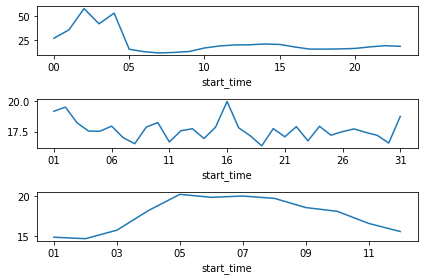

In [15]:
#Looking at average duration of ride

df_ssn = df[['start_time','duration']]
df_ssn = df_ssn['duration']

#Group by hour
plt.subplot(3, 1, 1)
df_ssn.groupby(df['start_time'].dt.strftime('%H')).mean().plot()

#Group by day
plt.subplot(3, 1, 2)
df_ssn.groupby(df['start_time'].dt.strftime('%d')).mean().plot()

#Group by month
plt.subplot(3, 1, 3)
df_ssn.groupby(df['start_time'].dt.strftime('%m')).mean().plot()

plt.tight_layout()
plt.show()

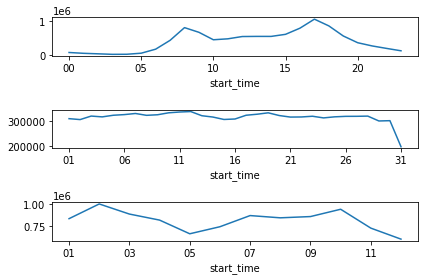

In [16]:
#Looking at ride freq (aka ride count) stats
#Group by hour
plt.subplot(3, 1, 1)
df_ssn.groupby(df['start_time'].dt.strftime('%H')).count().plot()

#Group by day
plt.subplot(3, 1, 2)
df_ssn.groupby(df['start_time'].dt.strftime('%d')).count().plot()

#Group by month
plt.subplot(3, 1, 3)
df_ssn.groupby(df['start_time'].dt.strftime('%m')).count().plot()

plt.tight_layout()
plt.show()

The graphs could be cleaner in python. Note that instead of spending time trying to visualize in python since the data source is small enough, we can just put it in Tableau and explore it that way, which is what we did next.